C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\2322399795.py:55: RuntimeWarning: invalid value encountered in divide
  radial_u = (x / distance_from_center)
C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\2322399795.py:56: RuntimeWarning: invalid value encountered in divide
  radial_v = (y / distance_from_center)


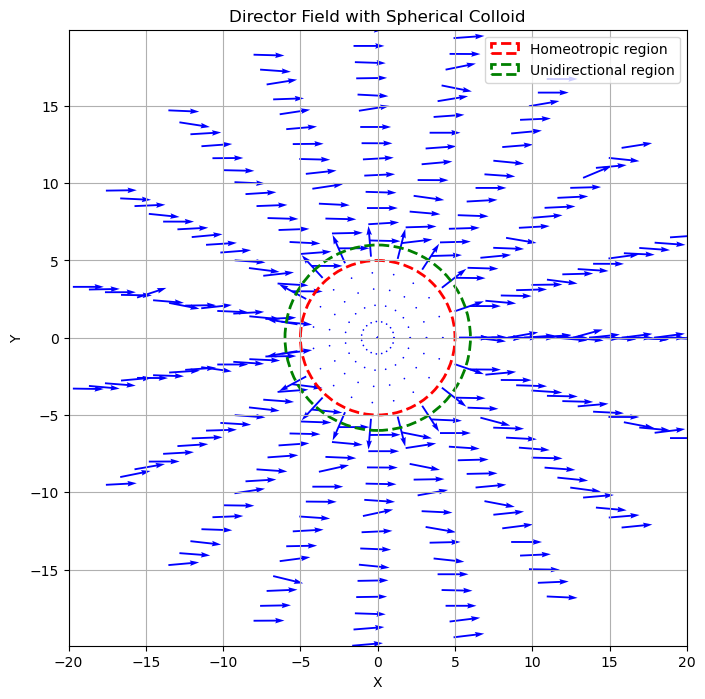

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def spherical_to_cartesian(r, theta):
    """
    Convert spherical coordinates to Cartesian coordinates.
    
    Parameters:
    r (np.ndarray): Radial distances.
    theta (np.ndarray): Azimuthal angles.
    
    Returns:
    tuple: Cartesian coordinates (x, y).
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def create_director_field_with_colloid(grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction):
    """
    Create a 2D director field around a spherical colloid with different alignments.
    
    Parameters:
    grid_size (tuple): Size of the grid (rows, cols).
    colloid_radius_inner (float): Inner radius of the spherical colloid (homeotropic region).
    colloid_radius_outer (float): Outer radius of the spherical colloid (beyond homeotropic region).
    alignment_direction (tuple): Direction of the uniform alignment beyond the outer radius (dx, dy).
    
    Returns:
    np.ndarray: 3D array where each entry is a unit vector representing the director.
    """
    rows, cols = grid_size
    dx, dy = alignment_direction

    # Normalize the alignment direction
    norm = np.sqrt(dx**2 + dy**2)
    dx, dy = dx / norm, dy / norm

    # Create spherical coordinates
    r = np.linspace(0, np.max(grid_size), rows)
    theta = np.linspace(0, 2 * np.pi, cols)
    r, theta = np.meshgrid(r, theta)
    
    # Convert spherical coordinates to Cartesian
    x, y = spherical_to_cartesian(r, theta)
    
    # Initialize the director field
    director_field = np.zeros((rows, cols, 2))
    
    # Compute distance from center
    distance_from_center = r
    
    # Set homeotropic alignment between radii [colloid_radius_inner, colloid_radius_outer]
    homeotropic_region = (distance_from_center >= colloid_radius_inner) & (distance_from_center <= colloid_radius_outer)
    radial_u = (x / distance_from_center)
    radial_v = (y / distance_from_center)
    radial_u = np.nan_to_num(radial_u)
    radial_v = np.nan_to_num(radial_v)
    director_field[homeotropic_region, 0] = radial_u[homeotropic_region]
    director_field[homeotropic_region, 1] = radial_v[homeotropic_region]

    # Set unidirectional alignment beyond the outer radius
    beyond_outer_radius = distance_from_center > colloid_radius_outer
    director_field[beyond_outer_radius, 0] = dx
    director_field[beyond_outer_radius, 1] = dy

    return director_field, x, y, distance_from_center

def monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, n_steps, delta_theta=0.1, energy_weight=1.0):
    """
    Perform Monte Carlo simulations to update the director field outside the outer radius of the colloid.
    
    Parameters:
    director_field (np.ndarray): 3D array with the initial director field.
    distance_from_center (np.ndarray): Distance from the colloid center.
    colloid_radius_outer (float): Outer radius of the spherical colloid.
    n_steps (int): Number of Monte Carlo steps.
    delta_theta (float): Perturbation angle for the director field.
    energy_weight (float): Weight of the energy term in acceptance criteria.
    
    Returns:
    np.ndarray: Updated director field.
    """
    rows, cols, _ = director_field.shape
    center_x, center_y = rows // 2, cols // 2
    
    for _ in range(n_steps):
        # Randomly select a point outside the outer radius
        i = np.random.randint(rows)
        j = np.random.randint(cols)
        if distance_from_center[i, j] > colloid_radius_outer:
            # Random perturbation angle
            theta_perturb = np.random.uniform(-delta_theta, delta_theta)
            cos_theta = np.cos(theta_perturb)
            sin_theta = np.sin(theta_perturb)
            
            # Current director
            u, v = director_field[i, j]
            new_u = cos_theta * u - sin_theta * v
            new_v = sin_theta * u + cos_theta * v
            new_norm = np.sqrt(new_u**2 + new_v**2)
            
            # Normalize
            new_u /= new_norm
            new_v /= new_norm
            
            # Compute radial direction at the point
            radial_u = (i - center_x) / distance_from_center[i, j]
            radial_v = (j - center_y) / distance_from_center[i, j]
            radial_u = np.nan_to_num(radial_u)
            radial_v = np.nan_to_num(radial_v)
            
            # Compute energy before and after the perturbation
            energy_before = 0.5 * (u * radial_u + v * radial_v - 1) ** 2
            energy_after = 0.5 * (new_u * radial_u + new_v * radial_v - 1) ** 2
            
            # Acceptance criterion: Metropolis algorithm
            if energy_after < energy_before or np.random.rand() < np.exp((energy_before - energy_after) / energy_weight):
                director_field[i, j] = [new_u, new_v]
    
    return director_field

def plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer):
    """
    Plot the 2D director field with a spherical colloid using quiver plot.
    
    Parameters:
    director_field (np.ndarray): 3D array with the director field.
    x (np.ndarray): Cartesian x coordinates.
    y (np.ndarray): Cartesian y coordinates.
    colloid_radius_inner (float): Inner radius of the colloid (homeotropic region).
    colloid_radius_outer (float): Outer radius of the colloid (beyond homeotropic region).
    """
    u = director_field[:, :, 0]
    v = director_field[:, :, 1]

    plt.figure(figsize=(8, 8))
    plt.quiver(x, y, u, v, scale=0.5, scale_units='xy', angles='xy', color='b')
    
    # Plot the colloid regions
    circle_inner = plt.Circle((0, 0), colloid_radius_inner, color='r', fill=False, linewidth=2, linestyle='--', label='Homeotropic region')
    circle_outer = plt.Circle((0, 0), colloid_radius_outer, color='g', fill=False, linewidth=2, linestyle='--', label='Unidirectional region')
    plt.gca().add_patch(circle_inner)
    plt.gca().add_patch(circle_outer)

    plt.xlim(-np.max(x), np.max(x))
    plt.ylim(-np.max(y), np.max(y))
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure x and y ratios are equal
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Director Field with Spherical Colloid')
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
grid_size = (20, 20)  # Grid size (rows, cols)
colloid_radius_inner = 5  # Inner radius of the colloid (homeotropic region)
colloid_radius_outer = 6  # Outer radius of the colloid (beyond homeotropic region)
alignment_direction = (1, 0)  # Uniform alignment direction beyond the outer radius (dx, dy)
n_steps = 1000  # Number of Monte Carlo steps
energy_weight = 1.0  # Weight of the energy term in the acceptance criterion

# Create and update the director field with Monte Carlo simulation
director_field, x, y, distance_from_center = create_director_field_with_colloid(
    grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction)
director_field = monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, n_steps, energy_weight=energy_weight)

# Plot the updated director field
plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer)


C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\244795221.py:27: RuntimeWarning: invalid value encountered in divide
  radial_u = (x / distance_from_center)
C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\244795221.py:28: RuntimeWarning: invalid value encountered in divide
  radial_v = (y / distance_from_center)


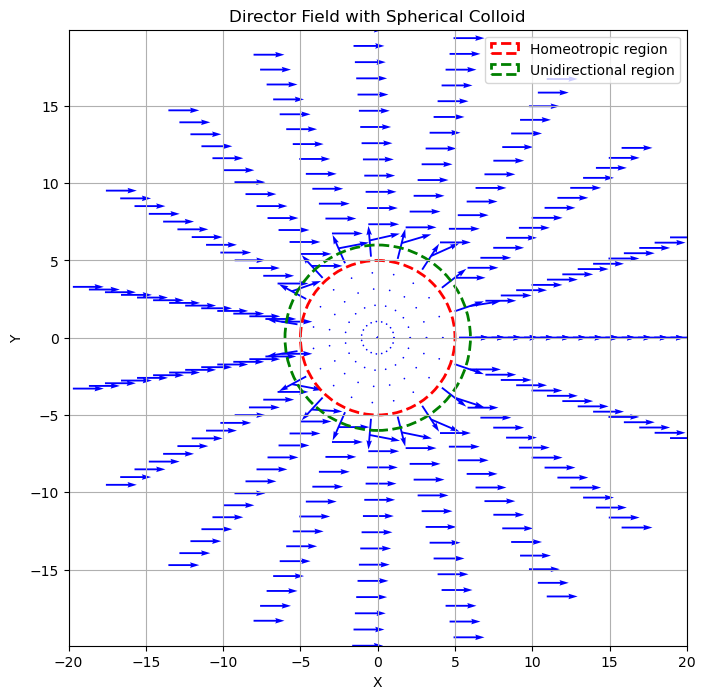

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def spherical_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def create_director_field_with_colloid(grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction):
    rows, cols = grid_size
    dx, dy = alignment_direction

    norm = np.sqrt(dx**2 + dy**2)
    dx, dy = dx / norm, dy / norm

    r = np.linspace(0, np.max(grid_size), rows)
    theta = np.linspace(0, 2 * np.pi, cols)
    r, theta = np.meshgrid(r, theta)
    
    x, y = spherical_to_cartesian(r, theta)
    
    director_field = np.zeros((rows, cols, 2))
    
    distance_from_center = r
    
    homeotropic_region = (distance_from_center >= colloid_radius_inner) & (distance_from_center <= colloid_radius_outer)
    radial_u = (x / distance_from_center)
    radial_v = (y / distance_from_center)
    radial_u = np.nan_to_num(radial_u)
    radial_v = np.nan_to_num(radial_v)
    director_field[homeotropic_region, 0] = radial_u[homeotropic_region]
    director_field[homeotropic_region, 1] = radial_v[homeotropic_region]

    beyond_outer_radius = distance_from_center > colloid_radius_outer
    director_field[beyond_outer_radius, 0] = dx
    director_field[beyond_outer_radius, 1] = dy

    return director_field, x, y, distance_from_center

def deformation_energy(director_field, i, j):
    rows, cols, _ = director_field.shape
    energy = 0.0
    
    # Neighbors (left, right, top, bottom)
    neighbors = [((i-1) % rows, j), ((i+1) % rows, j), (i, (j-1) % cols), (i, (j+1) % cols)]
    
    u, v = director_field[i, j]
    for ni, nj in neighbors:
        nu, nv = director_field[ni, nj]
        cos_theta = u * nu + v * nv
        energy += (1 - cos_theta)
    
    return energy

def monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, n_steps, delta_theta=0.5, energy_weight=1.0):
    rows, cols, _ = director_field.shape
    center_x, center_y = rows // 2, cols // 2
    
    for _ in range(n_steps):
        i = np.random.randint(rows)
        j = np.random.randint(cols)
        if distance_from_center[i, j] > colloid_radius_outer:
            theta_perturb = np.random.uniform(-delta_theta, delta_theta)
            cos_theta = np.cos(theta_perturb)
            sin_theta = np.sin(theta_perturb)
            
            u, v = director_field[i, j]
            new_u = cos_theta * u - sin_theta * v
            new_v = sin_theta * u + cos_theta * v
            new_norm = np.sqrt(new_u**2 + new_v**2)
            
            new_u /= new_norm
            new_v /= new_norm
            
            energy_before = deformation_energy(director_field, i, j)
            director_field[i, j] = [new_u, new_v]
            energy_after = deformation_energy(director_field, i, j)
            
            if energy_after > energy_before: #and np.random.rand() >= np.exp((energy_before - energy_after) / energy_weight):
                director_field[i, j] = [u, v]
    
    return director_field

def plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer):
    u = director_field[:, :, 0]
    v = director_field[:, :, 1]

    plt.figure(figsize=(8, 8))
    plt.quiver(x, y, u, v, scale=0.5, scale_units='xy', angles='xy', color='b')
    
    circle_inner = plt.Circle((0, 0), colloid_radius_inner, color='r', fill=False, linewidth=2, linestyle='--', label='Homeotropic region')
    circle_outer = plt.Circle((0, 0), colloid_radius_outer, color='g', fill=False, linewidth=2, linestyle='--', label='Unidirectional region')
    plt.gca().add_patch(circle_inner)
    plt.gca().add_patch(circle_outer)

    plt.xlim(-np.max(x), np.max(x))
    plt.ylim(-np.max(y), np.max(y))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Director Field with Spherical Colloid')
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
grid_size = (20, 20)
colloid_radius_inner = 5
colloid_radius_outer = 6
alignment_direction = (1, 0)
n_steps = 1000
energy_weight = 10.0

director_field, x, y, distance_from_center = create_director_field_with_colloid(
    grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction)
director_field = monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, n_steps, energy_weight=energy_weight)

plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer)


C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\3025057775.py:30: RuntimeWarning: invalid value encountered in divide
  radial_u = (x / distance_from_center)
C:\Users\gulati\AppData\Local\Temp\ipykernel_27368\3025057775.py:31: RuntimeWarning: invalid value encountered in divide
  radial_v = (y / distance_from_center)


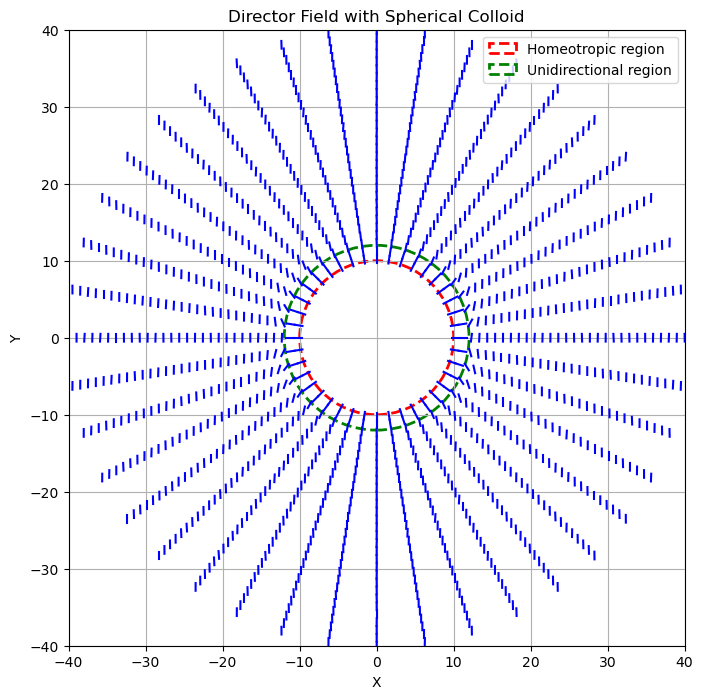

In [204]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 1.0
reduced_temp = 0.003

def spherical_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def create_director_field_with_colloid(grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction):
    rows, cols = grid_size
    dx, dy = alignment_direction

    norm = np.sqrt(dx**2 + dy**2)
    dx, dy = dx / norm, dy / norm

    r = np.linspace(0, np.max(grid_size), rows)
    theta = np.linspace(0, 2 * np.pi, cols, endpoint=False)
    r, theta = np.meshgrid(r, theta)
    
    x, y = spherical_to_cartesian(r, theta)
    
    director_field = np.zeros((rows, cols, 2))
    
    distance_from_center = r
    
    homeotropic_region = (distance_from_center >= colloid_radius_inner) & (distance_from_center <= colloid_radius_outer)
    radial_u = (x / distance_from_center)
    radial_v = (y / distance_from_center)
    radial_u = np.nan_to_num(radial_u)
    radial_v = np.nan_to_num(radial_v)
    director_field[homeotropic_region, 0] = radial_u[homeotropic_region]
    director_field[homeotropic_region, 1] = radial_v[homeotropic_region]

    beyond_outer_radius = distance_from_center > colloid_radius_outer
    director_field[beyond_outer_radius, 0] = dx
    director_field[beyond_outer_radius, 1] = dy

    return director_field, x, y, distance_from_center

def deformation_energy(director_field, i, j, distance_from_center, colloid_radius_inner, colloid_radius_outer):
    rows, cols, _ = director_field.shape
    energy = 0.0
    distance = distance_from_center[i, j]
    
    # Define a penalty factor based on distance
    penalty_factor = 1 + np.exp(-10* (distance - colloid_radius_outer) / (colloid_radius_outer - colloid_radius_inner))
    
    neighbors = [((i-1) % rows, j), ((i+1) % rows, j), (i, (j-1) % cols), (i, (j+1) % cols)]
    
    u, v = director_field[i, j]
    for ni, nj in neighbors:
        nu, nv = director_field[ni, nj]
        cos_diff = np.clip(u * nu + v * nv, -1.0, 1.0)
        #angle_diff = np.arccos(cos_theta)
        #if angle_diff > np.pi / 2:
        #    angle_diff = np.pi - angle_diff
        energy += -epsilon * penalty_factor* (cos_diff**2 - 1/3)
        energy_eps = energy / epsilon
    
    return energy_eps

def monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, colloid_radius_inner, n_steps, delta_theta=0.5, energy_weight=1.0):
    rows, cols, _ = director_field.shape
    
    for _ in range(n_steps):
        i = np.random.randint(rows)
        j = np.random.randint(cols)
        if distance_from_center[i, j] > colloid_radius_outer:
            theta_perturb = np.random.uniform(-delta_theta, delta_theta)
            cos_theta = np.cos(theta_perturb)
            sin_theta = np.sin(theta_perturb)
            
            u, v = director_field[i, j]
            new_u = cos_theta * u - sin_theta * v
            new_v = sin_theta * u + cos_theta * v
            new_norm = np.sqrt(new_u**2 + new_v**2)
            
            new_u /= new_norm
            new_v /= new_norm
            
            energy_before = deformation_energy(director_field, i, j, distance_from_center, colloid_radius_inner, colloid_radius_outer)
            director_field[i, j] = [new_u, new_v]
            energy_after = deformation_energy(director_field, i, j, distance_from_center, colloid_radius_inner, colloid_radius_outer)
            
            if energy_after > energy_before and np.random.rand() >= np.exp((energy_before - energy_after) / reduced_temp):
                director_field[i, j] = [u, v]
    
    return director_field

def plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer):
    u = director_field[:, :, 0]
    v = director_field[:, :, 1]

    plt.figure(figsize=(8, 8))
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i, j]**2 + y[i, j]**2) >= colloid_radius_inner**2:
                plt.plot([x[i, j] - u[i, j]/2, x[i, j] + u[i, j]/2], 
                         [y[i, j] - v[i, j]/2, y[i, j] + v[i, j]/2], 'b')

    circle_inner = plt.Circle((0, 0), colloid_radius_inner, color='r', fill=False, linewidth=2, linestyle='--', label='Homeotropic region')
    circle_outer = plt.Circle((0, 0), colloid_radius_outer, color='g', fill=False, linewidth=2, linestyle='--', label='Unidirectional region')
    plt.gca().add_patch(circle_inner)
    plt.gca().add_patch(circle_outer)

    plt.xlim(-np.max(x), np.max(x))
    plt.ylim(-np.max(y), np.max(y))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Director Field with Spherical Colloid')
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
grid_size = (40, 40)
colloid_radius_inner = 10
colloid_radius_outer = 12
alignment_direction = (0, 1)
n_steps = 100000
energy_weight = 1000

director_field, x, y, distance_from_center = create_director_field_with_colloid(
    grid_size, colloid_radius_inner, colloid_radius_outer, alignment_direction)
director_field = monte_carlo_update(director_field, distance_from_center, colloid_radius_outer, colloid_radius_inner, n_steps, energy_weight=energy_weight)

plot_director_field_with_colloid(director_field, x, y, colloid_radius_inner, colloid_radius_outer)


In [192]:
np.cos(1.5)

0.0707372016677029